In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio
from pypfm import PFMLoader
np.set_printoptions(formatter={"float": "{:10.2f}".format})

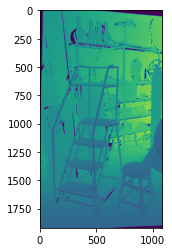

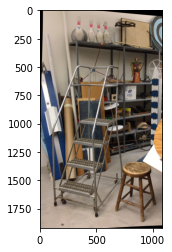

In [3]:
img_path = "/home/julian/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "/home/julian/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

loader = PFMLoader(color=False, compress=False)
pfm = loader.load_pfm(dispm_path)

for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        Z = baseline * f / (disp + doffs)
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0)

im = imageio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm,origin="upper")

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [5]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, eye_dome_lighting=True)

In [6]:
from src.dmcpworkflow.capture_depth import generate_depth_map

tup = generate_depth_map(mesh)

[[   1196.27       0.00     512.00]
 [      0.00     897.20     384.00]
 [      0.00       0.00       1.00]]


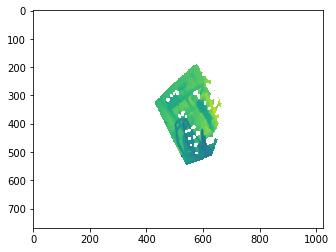

In [7]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [8]:
from src.dmcpworkflow.annotate_points import annotate

%matplotlib
cps = annotate(im[:,:,0],dm)
%matplotlib inline

Using matplotlib backend: <object object at 0x7f97ac47f680>


In [9]:
cps[:,2:] = cps[:,:2]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [10]:
cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

In [11]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,:2])
world_pts

array([[  -2028.95,   -1942.77,    7340.70],
       [  -1762.24,   -2064.57,    8073.70],
       [   -574.02,   -1986.41,    7634.55],
       [   -798.52,   -1841.17,    6917.84],
       [  -2758.09,    2447.37,    6945.18],
       [  -1202.94,    2591.74,    6382.96],
       [  -2096.46,    2500.84,    9048.82],
       [   -520.35,    2642.85,    8631.68]], dtype=float32)

In [13]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [25]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00       0.00      -0.00       0.00]
 [     -0.00       1.00       0.00      -0.00]
 [      0.00      -0.00       1.00       0.00]]
A
[[      0.67       0.66      -0.35    -202.93]
 [      0.29       0.20       0.93     136.99]
 [      0.69      -0.73      -0.06      -7.46]
 [      0.00       0.00       0.00       1.00]]


In [31]:
P_trans = P_im @ la.inv(A)

print("pose")
la.null_space(P_trans) / la.null_space(P_trans)[-1]

pose


array([[      0.00],
       [     -0.00],
       [      0.00],
       [      1.00]])

dmcp works with arbitrary transformation 